In [1]:
# load csv file and print the first 5 rows
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#df = pd.read_csv('datasets/target_model/CICIDS2017/combined_data_new_noSMOTE_0307_1.csv') # datasets\target_model\CICIDS2017\combined_data_0307_1.csv
# df


In [2]:
traindata = pd.read_csv('../datasets/target_model/CICIDS2018/train.csv') 
valdata = pd.read_csv('../datasets/target_model/CICIDS2018/val.csv')
testdata = pd.read_csv('../datasets/target_model/CICIDS2018/test.csv')
data = pd.concat([traindata, valdata, testdata], axis=0)
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [3]:
X_train = traindata.iloc[:, 0:-1]   
y_train = traindata.iloc[:, -1]
X_val = valdata.iloc[:, 0:-1]
y_val = valdata.iloc[:, -1]
X_test = testdata.iloc[:, 0:-1]
y_test = testdata.iloc[:, -1]

In [4]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [5]:
## create dataloaders by myself
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset = ClassifierDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset = ClassifierDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())

In [6]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = y.nunique()

In [7]:
NUM_CLASSES

2

In [8]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1,drop_last=True)

In [9]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [10]:
import torch
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

###################### OUTPUT ######################
cuda:0

cpu


In [11]:
from torch import optim

model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=42, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [12]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [13]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [14]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from datetime import datetime

print("Begin training.")
best_vloss = 1000000
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_acc_score = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        #print("train_data: ", X_train_batch, y_train_batch)
        # print train data shape  
        # X_train_batch:  torch.Size([64, 42]) y_train_batch torch.Size([64]) 
        # X_train_batch:  torch.Size([batch size, feature size]) y_train_batch torch.Size([batch size])
        #print("X_train_batch: ", X_train_batch.shape, "y_train_batch", y_train_batch.shape)
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        #print("X_train_batch: ", X_train_batch, "y_train_batch", y_train_batch)
        y_train_pred = model(X_train_batch)
        #print("y_train_pred: ", y_train_pred, y_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        # caculate train accuracy score from python package
        _, y_train_pred_tags = torch.max( y_train_pred, dim = 1)
        y_train_pred_tags.cpu().numpy()
        #train_acc_score = accuracy_score(y_train_batch,  y_train_pred_tags)
        #print("train_acc_score: ", train_acc_score)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        #train_epoch_acc_score += train_acc_score
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            #print("val_data: ", X_val_batch, y_val_batch)
            y_val_pred = model(X_val_batch)
            # print("y_val_pred: ", y_val_pred, y_val_batch)          
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    avg_vloss = val_epoch_loss/len(val_loader)       
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../target_model/target_DNN_model/binaryclass/targetDNN_model_{}_{}'.format(timestamp, EPOCHS) # target_model\target_DNN_model\binaryclass
        torch.save(model.state_dict(), model_path)                           
        torch.save(model, model_path + '.pth')    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Train Acc: {train_epoch_acc_score/len(train_loader):.3f}')

Begin training.


  2%|▏         | 1/50 [00:02<02:14,  2.74s/it]

Epoch 001: | Train Loss: 0.35109 | Val Loss: 0.25565 | Train Acc: 86.284| Val Acc: 90.784


  4%|▍         | 2/50 [00:05<02:07,  2.66s/it]

Epoch 002: | Train Loss: 0.28786 | Val Loss: 0.24048 | Train Acc: 89.804| Val Acc: 91.715


  6%|▌         | 3/50 [00:07<02:02,  2.61s/it]

Epoch 003: | Train Loss: 0.26922 | Val Loss: 0.23037 | Train Acc: 90.688| Val Acc: 92.025


  8%|▊         | 4/50 [00:10<01:58,  2.57s/it]

Epoch 004: | Train Loss: 0.25827 | Val Loss: 0.23340 | Train Acc: 91.192| Val Acc: 91.227


 10%|█         | 5/50 [00:13<01:56,  2.59s/it]

Epoch 005: | Train Loss: 0.24982 | Val Loss: 0.21792 | Train Acc: 91.435| Val Acc: 92.689


 12%|█▏        | 6/50 [00:15<01:52,  2.56s/it]

Epoch 006: | Train Loss: 0.24340 | Val Loss: 0.21599 | Train Acc: 91.839| Val Acc: 92.689


 14%|█▍        | 7/50 [00:18<01:49,  2.54s/it]

Epoch 007: | Train Loss: 0.23711 | Val Loss: 0.21080 | Train Acc: 91.968| Val Acc: 92.335


 16%|█▌        | 8/50 [00:20<01:46,  2.54s/it]

Epoch 008: | Train Loss: 0.23615 | Val Loss: 0.20427 | Train Acc: 92.009| Val Acc: 92.734


 18%|█▊        | 9/50 [00:23<01:43,  2.53s/it]

Epoch 009: | Train Loss: 0.23139 | Val Loss: 0.20348 | Train Acc: 92.271| Val Acc: 92.778


 20%|██        | 10/50 [00:25<01:40,  2.52s/it]

Epoch 010: | Train Loss: 0.22577 | Val Loss: 0.20244 | Train Acc: 92.366| Val Acc: 92.556


 22%|██▏       | 11/50 [00:28<01:38,  2.52s/it]

Epoch 011: | Train Loss: 0.22603 | Val Loss: 0.19995 | Train Acc: 92.322| Val Acc: 92.778


 24%|██▍       | 12/50 [00:30<01:36,  2.55s/it]

Epoch 012: | Train Loss: 0.22388 | Val Loss: 0.19750 | Train Acc: 92.407| Val Acc: 92.822


 26%|██▌       | 13/50 [00:33<01:33,  2.53s/it]

Epoch 013: | Train Loss: 0.22280 | Val Loss: 0.19482 | Train Acc: 92.549| Val Acc: 93.088


 28%|██▊       | 14/50 [00:35<01:30,  2.53s/it]

Epoch 014: | Train Loss: 0.22068 | Val Loss: 0.19994 | Train Acc: 92.716| Val Acc: 92.867


 30%|███       | 15/50 [00:38<01:28,  2.52s/it]

Epoch 015: | Train Loss: 0.21743 | Val Loss: 0.19758 | Train Acc: 92.726| Val Acc: 92.822


 32%|███▏      | 16/50 [00:40<01:25,  2.52s/it]

Epoch 016: | Train Loss: 0.21768 | Val Loss: 0.19203 | Train Acc: 92.763| Val Acc: 93.132


 34%|███▍      | 17/50 [00:43<01:22,  2.51s/it]

Epoch 017: | Train Loss: 0.21319 | Val Loss: 0.19488 | Train Acc: 93.000| Val Acc: 93.221


 36%|███▌      | 18/50 [00:45<01:21,  2.55s/it]

Epoch 018: | Train Loss: 0.21366 | Val Loss: 0.18741 | Train Acc: 93.028| Val Acc: 93.664


 38%|███▊      | 19/50 [00:48<01:18,  2.54s/it]

Epoch 019: | Train Loss: 0.21520 | Val Loss: 0.19016 | Train Acc: 92.915| Val Acc: 93.576


 40%|████      | 20/50 [00:50<01:15,  2.53s/it]

Epoch 020: | Train Loss: 0.21143 | Val Loss: 0.19515 | Train Acc: 92.893| Val Acc: 93.354


 42%|████▏     | 21/50 [00:53<01:13,  2.55s/it]

Epoch 021: | Train Loss: 0.21091 | Val Loss: 0.18729 | Train Acc: 93.098| Val Acc: 93.443


 44%|████▍     | 22/50 [00:56<01:11,  2.55s/it]

Epoch 022: | Train Loss: 0.20808 | Val Loss: 0.19050 | Train Acc: 93.085| Val Acc: 93.443


 46%|████▌     | 23/50 [00:58<01:09,  2.59s/it]

Epoch 023: | Train Loss: 0.20664 | Val Loss: 0.18570 | Train Acc: 93.174| Val Acc: 93.576


 48%|████▊     | 24/50 [01:01<01:06,  2.57s/it]

Epoch 024: | Train Loss: 0.20616 | Val Loss: 0.18511 | Train Acc: 93.243| Val Acc: 93.753


 50%|█████     | 25/50 [01:03<01:04,  2.56s/it]

Epoch 025: | Train Loss: 0.20547 | Val Loss: 0.17965 | Train Acc: 93.278| Val Acc: 94.107


 52%|█████▏    | 26/50 [01:06<01:01,  2.55s/it]

Epoch 026: | Train Loss: 0.20327 | Val Loss: 0.17754 | Train Acc: 93.344| Val Acc: 94.019


 54%|█████▍    | 27/50 [01:08<00:58,  2.54s/it]

Epoch 027: | Train Loss: 0.20450 | Val Loss: 0.17616 | Train Acc: 93.284| Val Acc: 94.019


 56%|█████▌    | 28/50 [01:11<00:55,  2.53s/it]

Epoch 028: | Train Loss: 0.20121 | Val Loss: 0.18475 | Train Acc: 93.319| Val Acc: 93.753


 58%|█████▊    | 29/50 [01:13<00:53,  2.56s/it]

Epoch 029: | Train Loss: 0.19959 | Val Loss: 0.17395 | Train Acc: 93.483| Val Acc: 94.019


 60%|██████    | 30/50 [01:16<00:50,  2.54s/it]

Epoch 030: | Train Loss: 0.20149 | Val Loss: 0.17446 | Train Acc: 93.363| Val Acc: 94.152


 62%|██████▏   | 31/50 [01:18<00:48,  2.53s/it]

Epoch 031: | Train Loss: 0.19730 | Val Loss: 0.17727 | Train Acc: 93.691| Val Acc: 94.152


 64%|██████▍   | 32/50 [01:21<00:45,  2.52s/it]

Epoch 032: | Train Loss: 0.19800 | Val Loss: 0.17281 | Train Acc: 93.524| Val Acc: 93.797


 66%|██████▌   | 33/50 [01:23<00:42,  2.53s/it]

Epoch 033: | Train Loss: 0.19809 | Val Loss: 0.17576 | Train Acc: 93.391| Val Acc: 93.930


 68%|██████▊   | 34/50 [01:26<00:40,  2.53s/it]

Epoch 034: | Train Loss: 0.19399 | Val Loss: 0.16422 | Train Acc: 93.640| Val Acc: 93.974


 70%|███████   | 35/50 [01:29<00:38,  2.56s/it]

Epoch 035: | Train Loss: 0.19520 | Val Loss: 0.17149 | Train Acc: 93.666| Val Acc: 93.886


 72%|███████▏  | 36/50 [01:31<00:35,  2.56s/it]

Epoch 036: | Train Loss: 0.19550 | Val Loss: 0.17494 | Train Acc: 93.713| Val Acc: 93.797


 74%|███████▍  | 37/50 [01:34<00:33,  2.57s/it]

Epoch 037: | Train Loss: 0.19671 | Val Loss: 0.17934 | Train Acc: 93.700| Val Acc: 94.329


 76%|███████▌  | 38/50 [01:37<00:31,  2.61s/it]

Epoch 038: | Train Loss: 0.19363 | Val Loss: 0.16845 | Train Acc: 93.571| Val Acc: 93.886


 78%|███████▊  | 39/50 [01:39<00:28,  2.59s/it]

Epoch 039: | Train Loss: 0.19116 | Val Loss: 0.16758 | Train Acc: 93.707| Val Acc: 94.595


 80%|████████  | 40/50 [01:42<00:25,  2.57s/it]

Epoch 040: | Train Loss: 0.19152 | Val Loss: 0.16440 | Train Acc: 93.814| Val Acc: 94.329


 82%|████████▏ | 41/50 [01:44<00:23,  2.56s/it]

Epoch 041: | Train Loss: 0.19004 | Val Loss: 0.16765 | Train Acc: 93.681| Val Acc: 94.196


 84%|████████▍ | 42/50 [01:47<00:20,  2.62s/it]

Epoch 042: | Train Loss: 0.18848 | Val Loss: 0.15957 | Train Acc: 93.836| Val Acc: 94.462


 86%|████████▌ | 43/50 [01:49<00:18,  2.61s/it]

Epoch 043: | Train Loss: 0.18887 | Val Loss: 0.15583 | Train Acc: 93.722| Val Acc: 94.417


 88%|████████▊ | 44/50 [01:52<00:15,  2.59s/it]

Epoch 044: | Train Loss: 0.18572 | Val Loss: 0.15921 | Train Acc: 93.811| Val Acc: 94.506


 90%|█████████ | 45/50 [01:55<00:12,  2.57s/it]

Epoch 045: | Train Loss: 0.18703 | Val Loss: 0.15162 | Train Acc: 93.811| Val Acc: 94.284


 92%|█████████▏| 46/50 [01:57<00:10,  2.56s/it]

Epoch 046: | Train Loss: 0.18540 | Val Loss: 0.16750 | Train Acc: 93.839| Val Acc: 93.930


 94%|█████████▍| 47/50 [02:00<00:07,  2.57s/it]

Epoch 047: | Train Loss: 0.18302 | Val Loss: 0.15204 | Train Acc: 93.918| Val Acc: 94.816


 96%|█████████▌| 48/50 [02:02<00:05,  2.62s/it]

Epoch 048: | Train Loss: 0.18761 | Val Loss: 0.16194 | Train Acc: 93.849| Val Acc: 94.506


 98%|█████████▊| 49/50 [02:05<00:02,  2.59s/it]

Epoch 049: | Train Loss: 0.18114 | Val Loss: 0.15262 | Train Acc: 93.950| Val Acc: 94.860


100%|██████████| 50/50 [02:07<00:00,  2.56s/it]

Epoch 050: | Train Loss: 0.17792 | Val Loss: 0.15591 | Train Acc: 94.117| Val Acc: 94.019


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

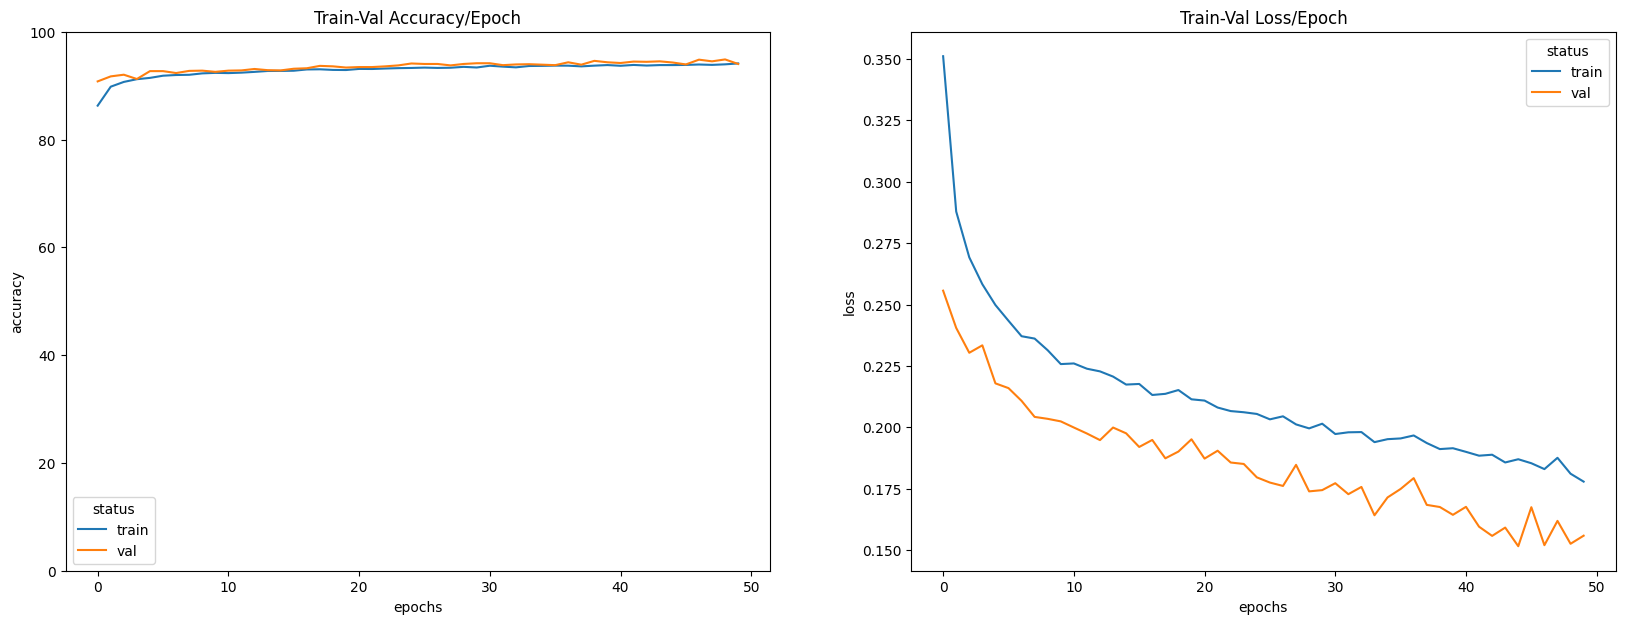

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# modify column names
train_val_acc_df.columns = ['epochs', 'status', 'accuracy']
train_val_loss_df.columns = ['epochs', 'status', 'loss']
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="accuracy", hue="status",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
# change the limits of y-axis
axes[0].set_ylim(0, 100) 
sns.lineplot(data=train_val_loss_df, x = "epochs", y="loss", hue="status", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [16]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        #print(_, y_pred_tags.cpu().numpy())
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [17]:
y_test.shape

(5642,)

In [18]:
len(y_pred_list)

5642

In [19]:
# test accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(y_test, y_pred_list))

0.9399149237858915


In [20]:
y_test = y_test
print(classification_report(y_test, y_pred_list, target_names=['Benign', 'Malicious'], digits=4))

              precision    recall  f1-score   support

      Benign     0.9499    0.9555    0.9527      3572
   Malicious     0.9224    0.9130    0.9177      2070

    accuracy                         0.9399      5642
   macro avg     0.9362    0.9343    0.9352      5642
weighted avg     0.9398    0.9399    0.9398      5642



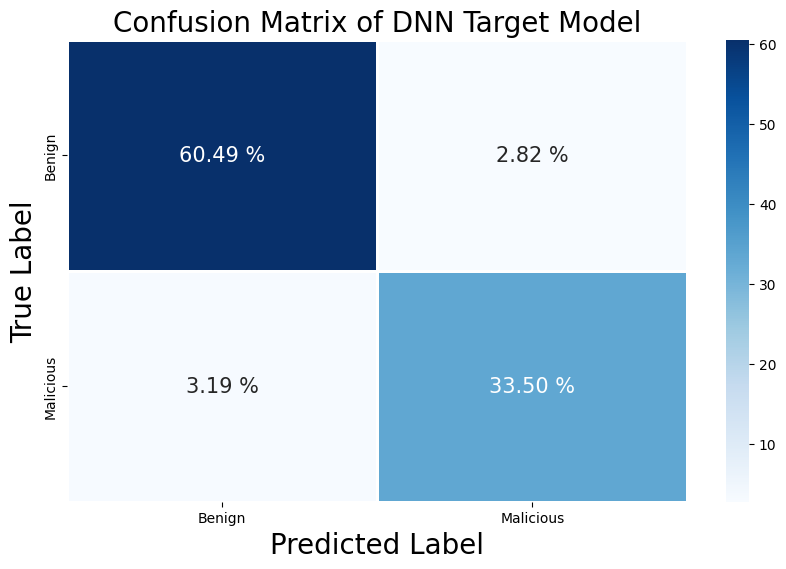

In [21]:
cm = confusion_matrix(y_test, y_pred_list, labels=traindata['Label'].unique() )
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of DNN Target Model', fontsize=20)
plt.show()